In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
!ls /kaggle/input/imdb-dataset-of-50k-movie-reviews

'IMDB Dataset.csv'


Using device: cuda
Epoch 1/6 | Train Loss: 0.6827 | Test Loss: 0.6498
Epoch 2/6 | Train Loss: 0.5677 | Test Loss: 0.3960
Epoch 3/6 | Train Loss: 0.2993 | Test Loss: 0.3174
Epoch 4/6 | Train Loss: 0.1969 | Test Loss: 0.2586
Epoch 5/6 | Train Loss: 0.1360 | Test Loss: 0.2807
Epoch 6/6 | Train Loss: 0.0780 | Test Loss: 0.3000


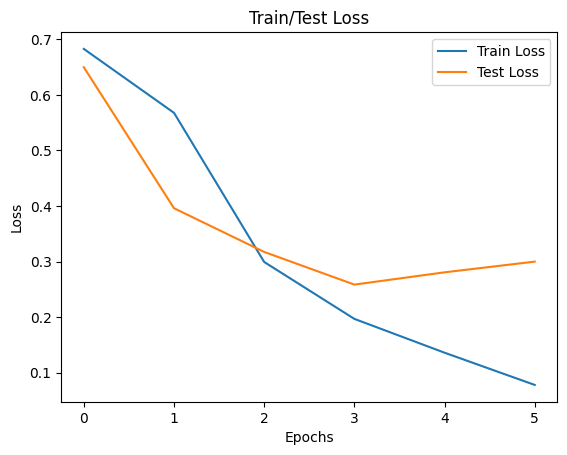

Test Accuracy: 89.77%


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt

# -------------------------
# 1️⃣ Device
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------
# 2️⃣ Load IMDB dataset
# -------------------------
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

# Encode labels
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

# -------------------------
# 3️⃣ Tokenize and Vocabulary
# -------------------------
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

df['tokens'] = df['review'].apply(tokenize)

all_tokens = [token for tokens in df['tokens'] for token in tokens]
vocab = {word: idx + 2 for idx, (word, _) in enumerate(Counter(all_tokens).items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode(tokens):
    return [vocab.get(token, 1) for token in tokens]

df['encoded'] = df['tokens'].apply(encode)

# -------------------------
# 4️⃣ Padding
# -------------------------
max_len = 300
def pad_sequence(seq):
    return seq[:max_len] + [0]*(max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

df['padded'] = df['encoded'].apply(pad_sequence)

# -------------------------
# 5️⃣ Train/Test split
# -------------------------
X = np.array(df['padded'].tolist())
y = np.array(df['sentiment'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

# -------------------------
# 6️⃣ LSTM Model
# -------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=200, hidden_dim=256, output_dim=1, n_layers=2, bidirectional=True, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, batch_first=True,
                            bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        out = self.fc(hidden)
        return self.sigmoid(out)

model = LSTMClassifier(vocab_size=len(vocab)).to(device)

# -------------------------
# 7️⃣ Training
# -------------------------
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

epochs = 6
train_losses, test_losses = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)

    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    test_loss = total_loss / len(test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

# -------------------------
# 8️⃣ Loss Curves
# -------------------------
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Test Loss')
plt.show()

# -------------------------
# 9️⃣ Evaluate Accuracy
# -------------------------
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


In [ ]:
# 🔟 Prediction
def predict_sentiment(review, model, vocab, max_len, device):
    model.eval()
    tokens = tokenize(review)
    encoded = encode(tokens)
    padded = pad_sequence(encoded)
    input_tensor = torch.tensor(padded, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor).squeeze()
        prediction = (output > 0.5).item()
    return "Positive" if prediction == 1 else "Negative", output.item()

# Example prediction
sample_review = "This movie was absolutely amazing! I loved every part of it."
sentiment, probability = predict_sentiment(sample_review, model, vocab, max_len, device)
print(f"Review: \"{sample_review}\"")
print(f"Predicted Sentiment: {sentiment} (Probability: {probability:.4f})")

sample_review_2 = "This movie was terrible. I hated it."
sentiment_2, probability_2 = predict_sentiment(sample_review_2, model, vocab, max_len, device)
print(f"Review: \"{sample_review_2}\"")
print(f"Predicted Sentiment: {sentiment_2} (Probability: {probability_2:.4f})")

Review: "This movie was absolutely amazing! I loved every part of it."
Predicted Sentiment: Positive (Probability: 0.9903)
Review: "This movie was terrible. I hated it."
Predicted Sentiment: Negative (Probability: 0.0013)


In [ ]:
model.eval()

LSTMClassifier(
  (embedding): Embedding(101946, 200, padding_idx=0)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)